# rechunk data and compute spectra 

We use zarr files and apply_ufunc (with a wrapper around scipy.signal.welsh)


---

In [16]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

In [3]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.start_workers(20)

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [4]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [5]:
client

Client Scheduler: tcp://10.148.1.14:51792 Dashboard: http://10.148.1.14:8787/status,Cluster Workers: 14 Cores: 56 Memory: 700.00 GB


--- 

# load data

In [13]:
V = ['SSU', 'SSV']

# faces
#F = range(13)
F = range(2)

# parameters for rechunking
Nt = 24*10 # time chunks
Nc = 96 # x 45 = 4320
# other choices: 432, 27 (long scheduling), 288, 864

In [27]:
#%load_ext autoreload
%autoreload

In [ ]:
for face in F:

    # binary to zarr (standard layout)
    %time zarr(V, client,  F=face)
    
    # rechunk all variables
    %time rechunk(V, F=face, Nt=Nt, Nc=Nc)
    
    # load data
    dsu = xr.open_zarr(scratch+'mit/rechunked/%s_f%02d.zarr'%('SSU',face))
    dsv = xr.open_zarr(scratch+'mit/rechunked/%s_f%02d.zarr'%('SSV',face))
    ds = xr.merge([dsu,dsv])
    ds = ds.assign_coords(time_days=ds['time']/86400.)

    ds['SSUV'] = ds['SSU'] + 1j * ds['SSV']
    
    # need to run once to get frequency
    f, E = get_E(ds['SSUV'].isel(i=slice(2),j=slice(2)))
    #
    E = get_E(ds['SSUV'], f=f)
    
    # store
    E = E.to_dataset()
    # tmp, waiting for xarray release 
    for v in E.variables:
        if hasattr(E[v],'encoding') and 'chunks' in E[v].encoding:
            del E[v].encoding['chunks']    
    #
    %time E.to_zarr(scratch+'mit/spectra/%s_f%02d.zarr'%('SSUV',face), mode='w', \
                    encoding={'SSUV': {'compressor': None}})

    # clean up
    for v in V:
        os.rmdir(scratch+'mit/standard/%s.zarr' %v)
        os.rmdir(scratch+'mit/rechunked/%s_f%02d.zarr'%(v,face))
        
    print('--- face %d done'%face)
        

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/mds_store.py:735: UserWarning: Couldn't find available_diagnostics.log in . Using default version.
  "in %s. Using default version." % data_dir)
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/mds_store.py:249: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%

   data is 192.6GB 


---
# inspect result

In [26]:
v = 'SUV'
E = xr.open_zarr(scratch+'mit/spectra/%s_f%02d.zarr'%(v,face))[v].fillna(0.)
E = E.persist()
print(E)
print('\n data size: %.1f GB' %(E.nbytes / 1e9))

<xarray.DataArray 'SSU' (j: 4320, i: 4320, freq_time: 1920)>
dask.array<shape=(4320, 4320, 1920), dtype=float64, chunksize=(96, 96, 1920)>
Coordinates:
    face       int64 ...
  * freq_time  (freq_time) float64 -12.0 -11.99 -11.98 -11.96 -11.95 -11.94 ...
  * i          (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j          (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...

 data size: 286.7 GB


In [27]:
print(E.min().values)
print(E.max().values)
# for some reason there are few crazy values, to verify
E = E.where(abs(E)<1e10, other=0.)

0.0
inf


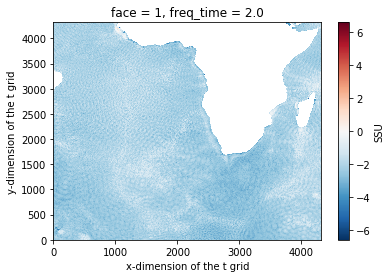

In [28]:
np.log10(E.sel(freq_time=2., method='nearest')).plot()

In [34]:
df = E.freq_time[1]-E.freq_time[0]
E2 = E.where(abs(abs(E.freq_time)-2.)<.2, other=0.).sum(dim='freq_time')*df
E2 = E2.where(E2>0)
print(E2)

<xarray.DataArray (j: 4320, i: 4320)>
dask.array<shape=(4320, 4320), dtype=float64, chunksize=(96, 96)>
Coordinates:
    face     int64 1
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...


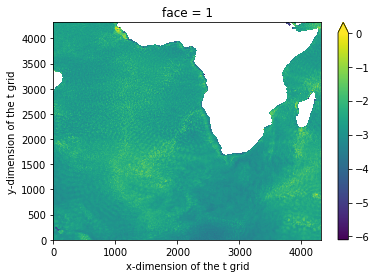

In [36]:
np.log10(E2).plot(vmax=0)

---

In [ ]:
w = cluster.start_workers(10)

In [73]:
# kill scheduler, workers
cluster.scheduler.close()
#cluster.stop_workers(cluster.jobs)

<Future pending cb=[_make_coroutine_wrapper.<locals>.wrapper.<locals>.<lambda>() at /home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/tornado/gen.py:336]>

In [ ]:
client.restart()